#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import time

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.isnull().sum()

num_orders    0
dtype: int64

In [4]:
df.index.is_monotonic

True

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df = df.resample("1H").sum()

Провели обработку данных для временного ряда:

Datetime сделали индексом, с типом Datetime

Проверили данные на монотонность. 

Провели ресемплинг с диапозоном в 1 час ,где данные агрегировали с помощью суммы

## Анализ

<AxesSubplot:xlabel='datetime'>

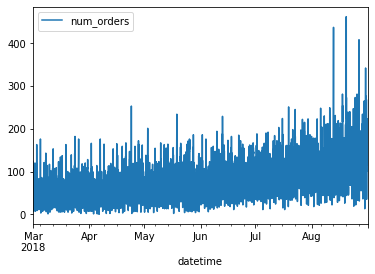

In [7]:
df.plot()

Построим графики тренда и сезонности

<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

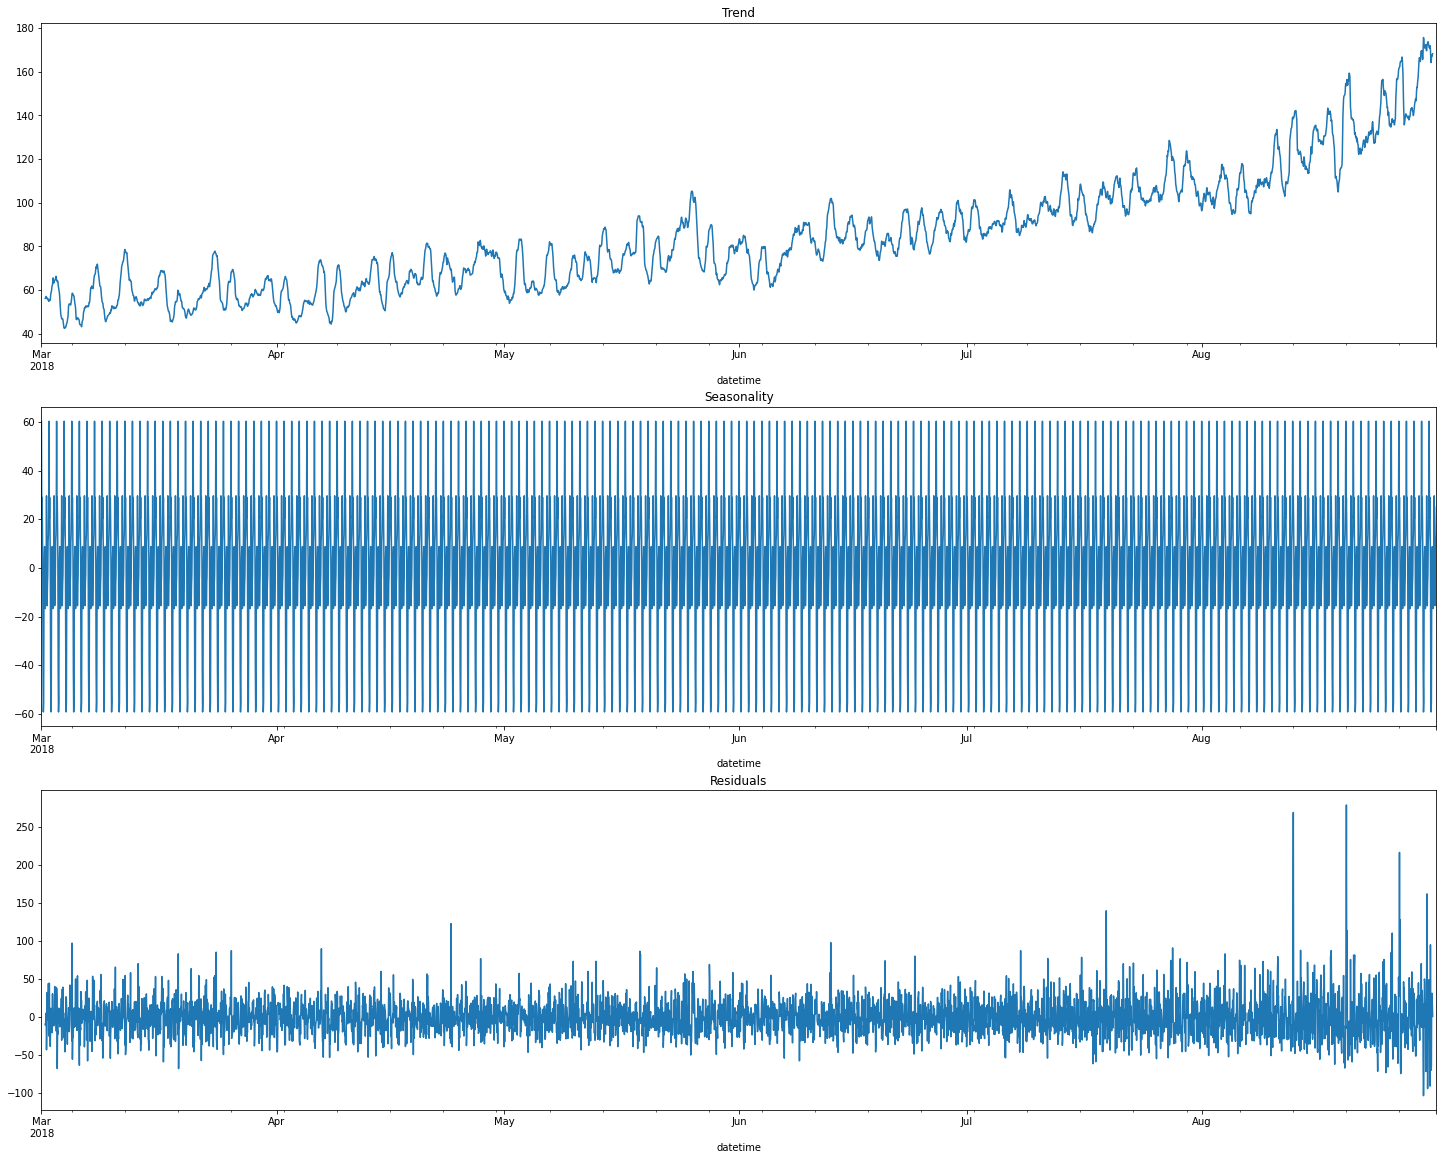

In [8]:
decomposed = seasonal_decompose(df)
fig,ax = plt.subplots(3,1,figsize = (25,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

Рассмотри интервалы поменьше
Месяц

и неделя в разные месяцы

<AxesSubplot:title={'center':'Trend month'}, xlabel='datetime'>

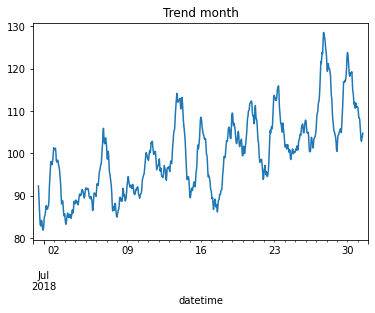

In [9]:
decomposed_month  = seasonal_decompose(df['2018-06-30':'2018-07-31'])
decomposed_month.trend.plot(title = 'Trend month')

<AxesSubplot:title={'center':'Trend week'}, xlabel='datetime'>

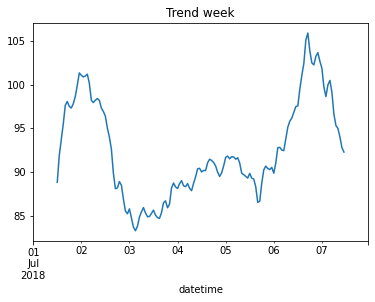

In [10]:
decomposed_week  = seasonal_decompose(df['2018-07-01':'2018-07-07'])
decomposed_week.trend.plot(title = 'Trend week')

<AxesSubplot:title={'center':'Trend week'}, xlabel='datetime'>

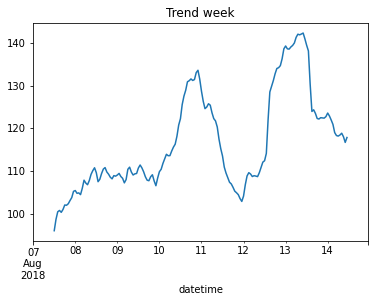

In [11]:
decomposed_week  = seasonal_decompose(df['2018-08-07':'2018-08-14'])
decomposed_week.trend.plot(title = 'Trend week')

Заметим что присутствуеут сезонность
Существует зависимость колличества заказов от месяца, дня недели и часа

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Функция для подготовки признаков для будущего обучения модели 
Также добавили отстающие значения и скользящее среднее , со смещением 

In [13]:
make_features(df, 27, 4)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   hour          4416 non-null   int64  
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

## Обучение

In [15]:
RNS=12345

Разделим на обучающую и тестовую выборку

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state = RNS)
train = train.dropna()

Выделим критерии и таргет 

In [17]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

### LinearRegression

In [18]:
model_LR = LinearRegression()
start = time.time()
model_LR.fit(train_features, train_target)
end = time.time()
time_fit_LR = end - start

start = time.time()
prediction_LR = model_LR.predict(train_features)
end = time.time()
time_predict_LR = end - start

### CatBoostRegressor

In [19]:
model_CBR = CatBoostRegressor(random_state = RNS)
parameters = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
              'iterations'    : [1000, 2000]
              }
tscv = TimeSeriesSplit(n_splits=2)
grid = GridSearchCV(model_CBR, param_grid = parameters, cv = tscv, scoring = 'neg_root_mean_squared_error',n_jobs=-1)
grid.fit(train_features, train_target)

print(" Results from Grid Search " )

print("\n The best parameters:\n", grid.best_params_)

0:	learn: 30.0232704	total: 47.6ms	remaining: 47.6s
1:	learn: 29.6962084	total: 48.9ms	remaining: 24.4s
2:	learn: 29.3489594	total: 50.2ms	remaining: 16.7s
3:	learn: 29.0605693	total: 51.4ms	remaining: 12.8s
4:	learn: 28.7416442	total: 52.7ms	remaining: 10.5s
5:	learn: 28.4732358	total: 53.8ms	remaining: 8.92s
6:	learn: 28.1944403	total: 54.9ms	remaining: 7.79s
7:	learn: 27.9260611	total: 56.1ms	remaining: 6.95s
8:	learn: 27.6366957	total: 57.2ms	remaining: 6.3s
9:	learn: 27.3636183	total: 58.3ms	remaining: 5.77s
10:	learn: 27.1297784	total: 59.6ms	remaining: 5.36s
11:	learn: 26.9060779	total: 60.8ms	remaining: 5s
12:	learn: 26.6732541	total: 61.9ms	remaining: 4.7s
13:	learn: 26.4776530	total: 63.1ms	remaining: 4.44s
14:	learn: 26.2664021	total: 64.3ms	remaining: 4.22s
15:	learn: 26.0468103	total: 65.4ms	remaining: 4.02s
16:	learn: 25.8345158	total: 66.6ms	remaining: 3.85s
17:	learn: 25.6114042	total: 67.6ms	remaining: 3.69s
18:	learn: 25.4619219	total: 68.9ms	remaining: 3.56s
19:	lear

In [20]:
%%time
model_CBR = CatBoostRegressor(depth=3, 
                              learning_rate=0.3,
                              iterations = 2000)
start = time.time()
model_CBR.fit(train_features, train_target)
end = time.time()
time_fit_CBR = end - start

0:	learn: 34.1810404	total: 1.96ms	remaining: 3.91s
1:	learn: 31.4027642	total: 4.41ms	remaining: 4.41s
2:	learn: 29.4264168	total: 6.89ms	remaining: 4.59s
3:	learn: 28.0536760	total: 8.77ms	remaining: 4.37s
4:	learn: 27.1189659	total: 10.7ms	remaining: 4.29s
5:	learn: 26.5470929	total: 13.2ms	remaining: 4.38s
6:	learn: 26.0506258	total: 15.1ms	remaining: 4.29s
7:	learn: 25.6914922	total: 17.1ms	remaining: 4.25s
8:	learn: 25.3860509	total: 19ms	remaining: 4.21s
9:	learn: 25.2026257	total: 21ms	remaining: 4.18s
10:	learn: 24.8296084	total: 23.6ms	remaining: 4.27s
11:	learn: 24.7677824	total: 25.9ms	remaining: 4.29s
12:	learn: 24.7158835	total: 27.9ms	remaining: 4.26s
13:	learn: 24.6706333	total: 29.7ms	remaining: 4.21s
14:	learn: 24.4480094	total: 31.3ms	remaining: 4.14s
15:	learn: 24.3377679	total: 33.5ms	remaining: 4.16s
16:	learn: 24.1901131	total: 35.7ms	remaining: 4.16s
17:	learn: 24.1107472	total: 37.6ms	remaining: 4.14s
18:	learn: 24.0585785	total: 39.5ms	remaining: 4.12s
19:	lea

In [21]:
start = time.time()
prediction_CBR = model_CBR.predict(train_features)
end = time.time()
time_predict_CBR = end - start

### RandomForestRegressor

In [22]:
%%time
model_RF = RandomForestRegressor(random_state=RNS)
n_estimators = [100, 200 , 300]
max_depth = [9,10,11]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth
             }
tscv = TimeSeriesSplit(n_splits=2)
gs = GridSearchCV(model_RF,  param_grid, cv = tscv, scoring = 'neg_root_mean_squared_error',n_jobs=-1)
gs.fit(train_features, train_target)
rfc_3 = gs.best_estimator_
gs.best_params_

CPU times: user 1min 24s, sys: 286 ms, total: 1min 24s
Wall time: 1min 24s


{'max_depth': 11, 'n_estimators': 200}

In [23]:
%%time
model_RF = RandomForestRegressor(random_state=RNS,n_estimators = 200, max_depth=11, n_jobs=-1)
start=time.time()
model_RF.fit(train_features, train_target)
end = time.time()
time_fit_RF = end - start

CPU times: user 8.83 s, sys: 76.1 ms, total: 8.91 s
Wall time: 8.92 s


In [24]:
start = time.time()
prediction_RF = model_RF.predict(train_features)
end = time.time()
time_predict_RF = end - start

### LGBMRegressor

In [25]:
%%time
model_LG = LGBMRegressor(random_state=RNS)
param_grid = {'max_depth': [5,7,9],
              'num_leaves': [50,60,70],
              'learning_rate' : [0.03, 0.1],
              'n_estimators' : [100,200,1000]
            }
tscv = TimeSeriesSplit(n_splits=2)
grid = GridSearchCV(model_LG, param_grid, cv = tscv, scoring = 'neg_root_mean_squared_error')
grid.fit(train_features, train_target)

print(" Results from Grid Search " )

print("\n The best parameters:\n", grid.best_params_)


 Results from Grid Search 

 The best parameters:
 {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 1000, 'num_leaves': 50}
CPU times: user 25min 55s, sys: 14.4 s, total: 26min 10s
Wall time: 26min 19s


In [26]:
%%time
model_LG = LGBMRegressor(random_state=RNS, learning_rate= 0.03, max_depth=5, n_estimators=1000, num_leaves=50)
start = time.time()
model_LG.fit(train_features, train_target)
end = time.time()
time_fit_LG = end - start

CPU times: user 5.61 s, sys: 50.2 ms, total: 5.66 s
Wall time: 5.69 s


In [27]:
start = time.time()
prediction_LG = model_LG.predict(train_features)
end = time.time()
time_predict_LG = end - start

## Тестирование

In [28]:
start = time.time()
prediction_LR = model_LR.predict(test_features)
end = time.time()

RMSE_LR_test = mean_squared_error(test_target,prediction_LR)**0.5
time_test_LR = end - start

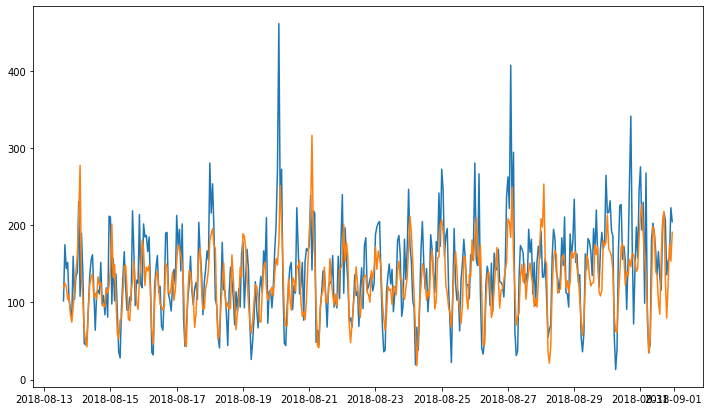

In [29]:
frame = {'Target':test_target, 'Prediction':prediction_LR}
frame = pd.DataFrame(frame) 
plt.figure(figsize=(12,7))
plt.plot(frame)

In [30]:
start = time.time()
prediction_CBR = model_CBR.predict(test_features)
end = time.time()
RMSE_CBR_test = mean_squared_error(test_target,prediction_CBR)**0.5
time_test_CBR = end - start

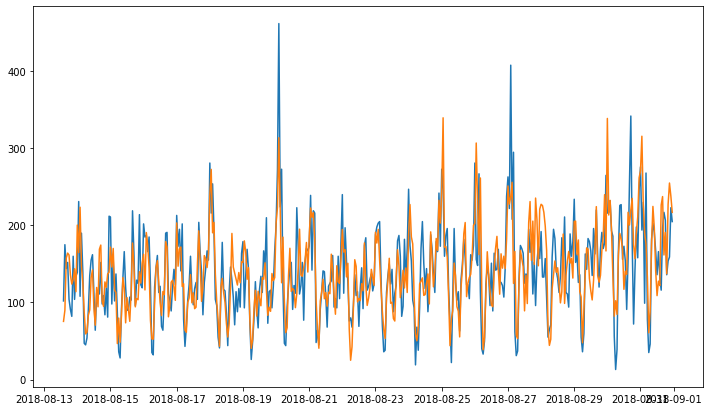

In [31]:
frame = {'Target':test_target, 'Prediction':prediction_CBR}
frame = pd.DataFrame(frame) 
plt.figure(figsize=(12,7))
plt.plot(frame)

In [32]:
start = time.time()
prediction_RF = model_RF.predict(test_features)
end = time.time()
RMSE_RF_test = mean_squared_error(test_target,prediction_RF)**0.5
time_test_RF = end - start

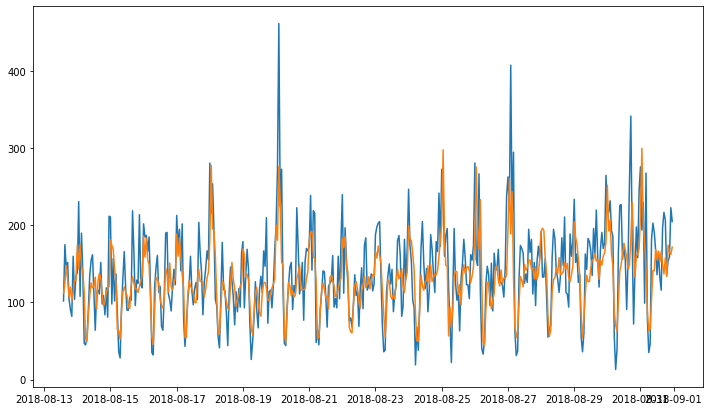

In [33]:
frame = {'Target':test_target, 'Prediction':prediction_RF}
frame = pd.DataFrame(frame) 
plt.figure(figsize=(12,7))
plt.plot(frame)

In [34]:
start = time.time()
prediction_LG = model_LG.predict(test_features)
end = time.time()
RMSE_LG_test = mean_squared_error(test_target,prediction_LG)**0.5
time_test_LG = end - start

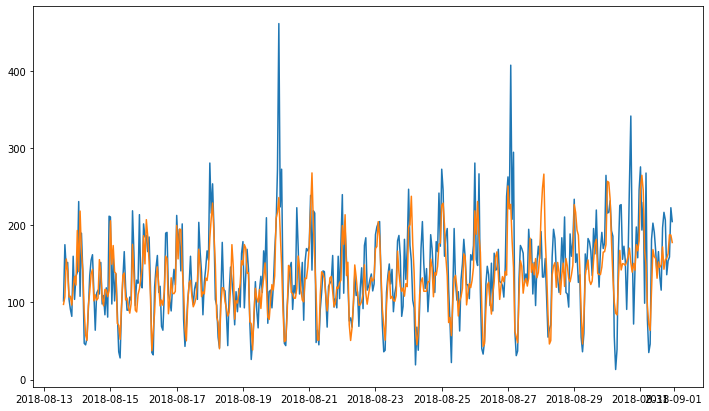

In [35]:
frame = {'Target':test_target, 'Prediction':prediction_LG}
frame = pd.DataFrame(frame) 
plt.figure(figsize=(12,7))
plt.plot(frame)

In [36]:
result = pd.DataFrame(columns=['RMSE_test','Time_fit', 'Time_predict_train', 'Time_predict_test'])

result.loc['LinearRegression','RMSE_test'] = RMSE_LR_test
result.loc['LinearRegression','Time_fit'] = time_fit_LR
result.loc['LinearRegression','Time_predict_train'] = time_fit_LR
result.loc['LinearRegression','Time_predict_test'] = time_test_LR


result.loc['CatBoostRegressor','RMSE_test'] = RMSE_CBR_test
result.loc['CatBoostRegressor','Time_fit'] = time_fit_CBR
result.loc['CatBoostRegressor','Time_predict_train'] = time_fit_CBR
result.loc['CatBoostRegressor','Time_predict_test'] = time_test_CBR


result.loc['RandomForestRegressor','RMSE_test'] = RMSE_RF_test
result.loc['RandomForestRegressor','Time_fit'] = time_fit_RF
result.loc['RandomForestRegressor','Time_predict_train'] = time_fit_RF
result.loc['RandomForestRegressor','Time_predict_test'] = time_test_RF


result.loc['LGBMRegressor','RMSE_test'] = RMSE_LG_test
result.loc['LGBMRegressor','Time_fit'] = time_fit_LG
result.loc['LGBMRegressor','Time_predict_train'] = time_fit_LG
result.loc['LGBMRegressor','Time_predict_test'] = time_test_LG

In [37]:
result

,RMSE_test,Time_fit,Time_predict_train,Time_predict_test
LinearRegression,46.127387,0.006492,0.006492,0.002761
CatBoostRegressor,43.669838,5.379272,5.379272,0.015367
RandomForestRegressor,42.85051,8.916463,8.916463,0.027907
LGBMRegressor,40.832225,5.691564,5.691564,0.060466


В таблице мы видим, что по условию RMSE нам подходят все модели, но наименьшую ошибку показывает LGBMRegressor.

наименьшее время обучения показала модель построенная на алгоритме LinearRegression

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48